# Idea
* Draw a high-resolution image of the network
  * Make sure each railway station has a unique color
  * Make sure the station nodes "cut" the railway line edges
  * Don't draw non-station nodes
* Use the image to construct a graph
  * Recover node attributes using node colors

In [2]:
import osmnx as ox

ox.config(log_console = True, data_folder = 'data')
graph = ox.load_graphml('northeuroperails_alt.graphml')

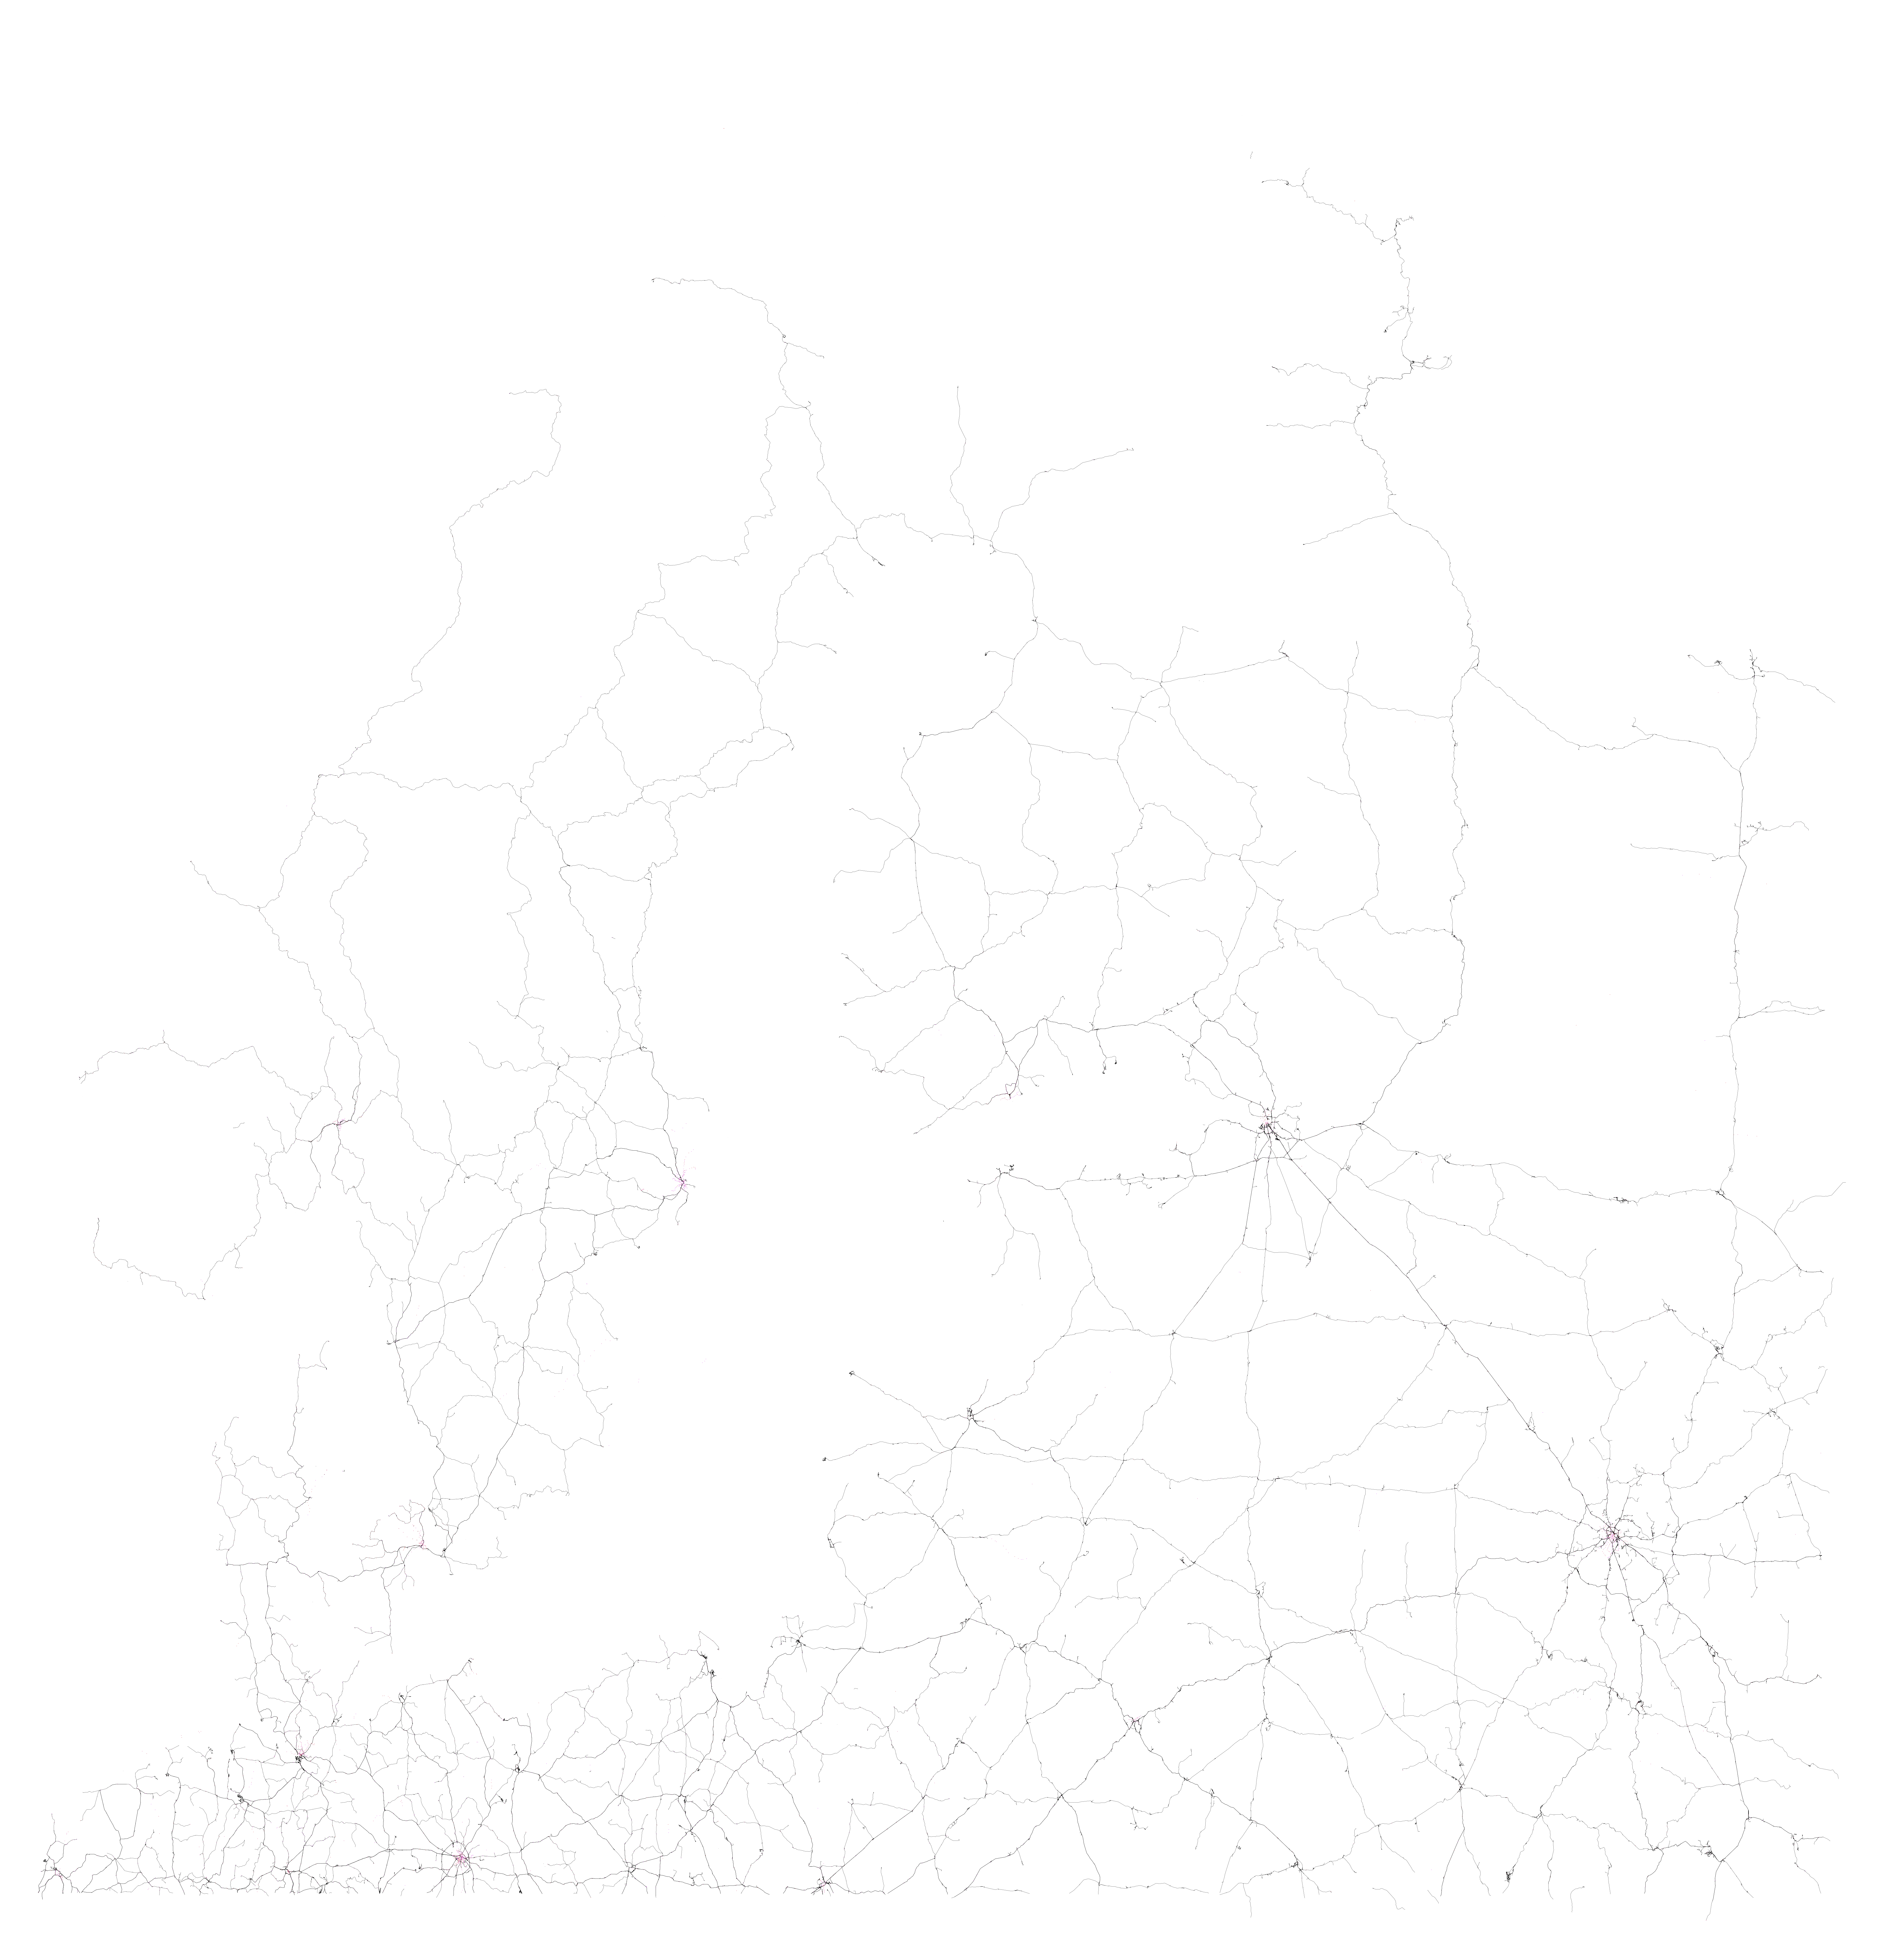

(<Figure size 18483.7x9216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27124156070>)

In [22]:
def iter_colors(start):
    '''
    Iterator that returns unique HTML colors in a sequence,
    starting from the given (r, g, b) start color
    '''
    r, g, b = start
    while r < 256:
        yield f'#{r:02x}{g:02x}{b:02x}'
        b += 1
        if r == g and g == b:
            b += 1
        if b > 255:
            b = 0
            g += 1
        if g > 255:
            g = 0
            r += 1

coloriterator = iter_colors((200, 0, 0))
node_colors = [next(coloriterator) if 'railway' in n and n['railway'] == 'station' else '#000000' for n in graph.nodes.values()]
# Set the size of non-railway nodes to 0 in order to not draw them
node_sizes = [1.5 if 'railway' in n and n['railway'] == 'station' else 0 for n in graph.nodes.values()]

ox.plot_graph(graph,
              fig_height=128,
              node_color = node_colors, edge_color='#000000',
              node_size = node_sizes, edge_linewidth=.25, node_zorder=3,
              save=True, filename='fig' # Gets saved as images/fig.png
            )

In [25]:
import imageio as imgio
from PIL import Image
import numpy as np
import networkx as nx

Image.MAX_IMAGE_PIXELS = None # Needed to load our huge image

def color_to_html(color):
    r, g, b = color
    return f'#{r:02x}{g:02x}{b:02x}'

def is_monochrome(color):
    return color[0] == color[1] and color[1] == color[2]

def is_way(color):
    return is_monochrome(color) and np.sum(color) < 512 # 512 is a magic number with which this just works : - D

def consume_node(img, startx, starty):
    '''
    Consumes a node starting at [startx, starty] by reading non-monochrome pixels around it
    and turning them white until there are none left.
    Also picks up ways surrounding the node.
    The node color is decided by a vote - the most used color is picked as the node color.
    '''
    if is_monochrome(img[startx, starty]):
        return None, []
    to_consume = [(startx, starty)]
    new_ways = []
    colors = {}
    while to_consume:
        nxt = to_consume.pop()
        if is_monochrome(img[nxt[0], nxt[1]]):
            continue # Already white -> ignore
        color = img[nxt[0], nxt[1]]
        ckey = color_to_html(color) # Keep track of found colors
        if ckey not in colors:
            colors[ckey] = 0
        colors[ckey] += 1
        img[nxt[0], nxt[1]] = [255, 255, 255] # Paint the current pixel white in order to not revisit it
        for d in ((0, 1), (1, 0), (0, -1), (-1, 0)): # Check the surroundings of the current pixel
            candidate = (nxt[0] + d[0], nxt[1] + d[1])
            if not is_monochrome(img[candidate[0], candidate[1]]): # Not monochrome -> part of a node
                to_consume.append(candidate)
            elif is_way(img[candidate[0], candidate[1]]):
                new_ways.append(candidate)
    node_color = max(colors, key=lambda c: colors[c])
    return node_color, new_ways

def consume_way(img, startx, starty):
    '''
    Consumes a way starting at [startx, starty] by reading dark, monochrome pixels around it
    and turning them white until there are none left.
    Also picks up nodes the way leads to.
    '''
    if not is_way(img[startx, starty]):
        return []
    to_consume = [(startx, starty)]
    new_nodes = []
    while to_consume:
        nxt = to_consume.pop()
        if is_monochrome(img[nxt[0], nxt[1]]) and not is_way(img[nxt[0], nxt[1]]):
            continue # Already white -> ignore
        img[nxt[0], nxt[1]] = [255, 255, 255] # Paint the current pixel white in order to not revisit it
        for d in ((0, 1), (1, 0), (0, -1), (-1, 0)): # Check the surroundings of the current pixel
            candidate = (nxt[0] + d[0], nxt[1] + d[1])
            if is_way(img[candidate[0], candidate[1]]):
                to_consume.append(candidate)
            elif not is_monochrome(img[candidate[0], candidate[1]]): # Not monochrome -> part of a node
                new_nodes.append(candidate)
    return new_nodes

def build_network(img_file, startx, starty):
    '''
    Consumes ways and nodes in the image, starting at the node in [startx, starty],
    and builds a network based on them
    '''
    img = imgio.imread(img_file)[:, :, :3] # Keep only r, g, b (drop a)
    nodes_to_consume = [(None, startx, starty)]
    ways_to_consume = []
    g = nx.Graph()
    while nodes_to_consume or ways_to_consume:
        if nodes_to_consume:
            frm, x, y = nodes_to_consume.pop()
            node, ways = consume_node(img, x, y)
            if node is not None:
                g.add_node(node)
                if frm is not None:
                    g.add_edge(frm, node)
                ways_to_consume.extend([(node, *way) for way in ways])
        if ways_to_consume:
            frm, x, y = ways_to_consume.pop()
            nodes = consume_way(img, x, y)
            nodes_to_consume.extend([(frm, *node) for node in nodes])
    return g

net = build_network('images/fig.png', 16256, 14942) # Helsinki railway station is at 16256, 14942

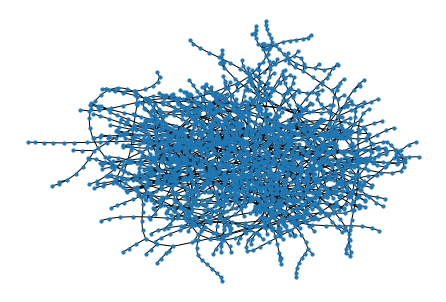

In [27]:
nx.draw(net, node_size=10)

# TODO
* Rebuild node attributes based on it's color (keep track of the attributes when assigning colors during image creation)
* Currently, this is basically a DFS starting from the start node, and therefore 